# Spatial Correlation Analysis of Uncertainty Heatmaps

In this notebook we apply common spatial correlation metrics used for greyscale images to uncertainty heatmaps.

Goals:
- Extract meaningful scores reflecting spatial correlation of uncertainty values: Noise vs Structure, "Local vs Global Uncertainty", etc.
- Apply these metrics to toy data and real uncertainty maps, compare them and assess their reliability in practice.

Metrics:
- Moran's I
- Geary's C
- Grey-level Co-occurence Matrix (GLCM)

Note: For GLCM, we consider its correlation component. However, this is almost identical to Moran's I (for the choice of radius=1 and angle=0). Hence we will focus more on Moran's I.

In [1]:
# Firstly, we import necessary packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

from aggrigator.uncertainty_maps import UncertaintyMap
from aggrigator.methods import AggregationMethods as am
from aggrigator.summary import AggregationSummary
from aggrigator.strategylist import StrategyList
from aggrigator.util import generate_disk_bdry_mask, generate_disk_mask
from aggrigator.datasets import generate_binary_quadrant_array, generate_checkerboard_array

%load_ext autoreload
%autoreload 2

## Basic Example

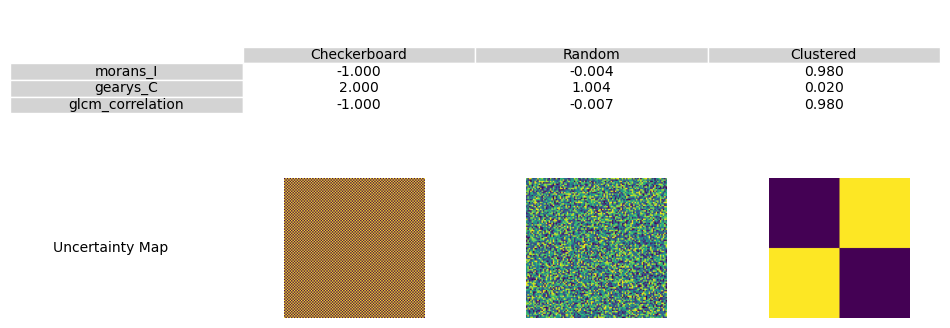

In [2]:
size = 100
array_1 = generate_checkerboard_array(size)
unc_map_1 = UncertaintyMap(array=array_1, mask=None, name="Checkerboard")

array_2 = np.random.random((100,100))
unc_map_2 = UncertaintyMap(array=array_2, mask=None, name="Random")

array_3 = generate_binary_quadrant_array(size)
unc_map_3 = UncertaintyMap(array=array_3, mask=None, name="Clustered")

summary = AggregationSummary(StrategyList.SPATIAL)
result = summary.apply_methods([unc_map_1, unc_map_2, unc_map_3], save_to_excel=False, do_plot=True, max_value=1.0)

# Analysis of Arctique Heatmaps

In [ ]:
def get_arctique_slice_arrays(slice, dataset):
    # Load arrays
    path = os.path.join(os.getcwd(), "..", "..", "data", dataset)
    files = os.listdir(path)
    arrays = [np.load(os.path.join(path, file)) for file in files] # 3D arrays, shape (50,512,512)
    #print(arrays[0].shape)
    #arrays = [array[slice,:,:] for array in arrays]
    arrays = [array for array in arrays]
    arrays = [np.where(array < 0, 0, array) for array in arrays]
    arrays = [np.where(array > 1, 1, array) for array in arrays]
    return arrays, files

# Test
SLICE = 25
DATASET = "crops_uq_maps"
arrays, filenames = get_arctique_slice_arrays(SLICE, DATASET)

In [12]:
print(arrays[0].max())

1.0


In [ ]:
# Get spatial aggregation summary
SLICE = 25
DATASET = "crops_uq_maps"

arrays, filenames = get_arctique_slice_arrays(SLICE, DATASET)
unc_maps = [UncertaintyMap(array=array, mask=None, name=name) for array, name in zip(arrays, filenames)]
strategy_list = [(am.gearys_C, None), (am.morans_I, None), (am.glcm_correlation, None), (am.mean, None)]

summary = AggregationSummary(strategy_list, name=f"spatial_analysis_{DATASET}_slice_{SLICE}", num_cpus=12)
spatial_df = summary.apply_methods(unc_maps, save_to_excel=False, do_plot=False, max_value=1.0)
spatial_df

Using 8 CPUs.


,Name,test_01_entropy.npy,test_01_error.npy,test_02_entropy.npy,test_02_error.npy,test_03_entropy.npy,test_03_error.npy,test_04_entropy.npy,test_04_error.npy,test_05_entropy.npy,...,test_22_entropy.npy,test_22_error.npy,test_23_entropy.npy,test_23_error.npy,test_24_entropy.npy,test_24_error.npy,test_25_entropy.npy,test_25_error.npy,test_26_entropy.npy,test_26_error.npy
0,gearys_C,0.033493,0.241789,0.111939,0.531856,0.110441,0.541912,0.099283,0.495486,0.116416,...,0.079858,0.436725,0.105909,0.553922,0.067631,0.508412,0.053160,0.281997,0.075347,0.384162
1,morans_I,0.965671,0.757947,0.888047,0.466609,0.890202,0.457882,0.899823,0.504456,0.883150,...,0.919850,0.561981,0.893833,0.445817,0.932135,0.491266,0.947436,0.719172,0.922385,0.616091
2,glcm_correlation,0.964894,0.758102,0.884382,0.466643,0.888336,0.473684,0.903696,0.515314,0.875994,...,0.925392,0.584502,0.897405,0.480117,0.931046,0.493925,0.939443,0.697652,0.909301,0.591002
3,mean,0.245265,0.105006,0.055951,0.022969,0.022766,0.010008,0.012975,0.005639,0.055784,...,0.011089,0.005622,0.005929,0.001803,0.033618,0.013256,0.010482,0.005636,0.004600,0.001967


## Plot Edge Case Heatmaps

In [14]:
# Plot 10 unc maps with lowest and highest values
import matplotlib.pyplot as plt

def plot_extremal_heatmaps(arrays, method, N=10):
    method_values = {i: spatial_df[spatial_df["Name"]==method][filenames[i]].values[0] for i in range(len(arrays))}

    vals_sorted_ascending = [idx for idx, val in sorted(method_values.items(), key=lambda x: x[1])]
    min_heatmaps = {i: arrays[i] for i in vals_sorted_ascending[:N]}
    max_heatmaps = {i: arrays[i] for i in vals_sorted_ascending[-N:]}

    fig, axes = plt.subplots(1, N, figsize=(3*N, 3))
    # Plot each image in a separate subplot
    for ax, (idx, img) in zip(axes, min_heatmaps.items()):
        ax.imshow(img, cmap="viridis", vmin=0, vmax=1)  # Plot as grayscale
        ax.axis("off")  # Hide axes for better visualization
        val = f"{method_values[idx]:.3f}"
        ax.text(0.5, -0.15, val, fontsize=12, ha="center", va="center", transform=ax.transAxes)  # Add text
    fig.suptitle(f"{N} minimal heatmaps for {method}", fontsize=16)

    fig, axes = plt.subplots(1, N, figsize=(3*N, 3))
    # Plot each image in a separate subplot
    for ax, (idx, img) in zip(axes, max_heatmaps.items()):
        ax.imshow(img, cmap="viridis", vmin=0, vmax=1)  # Plot as grayscale
        ax.axis("off")  # Hide axes for better visualization
        val = f"{method_values[idx]:.3f}"
        ax.text(0.5, -0.15, val, fontsize=12, ha="center", va="center", transform=ax.transAxes)  # Add text
    fig.suptitle(f"{N} maximal heatmaps for {method}", fontsize=16)

    plt.show()


Moran's I


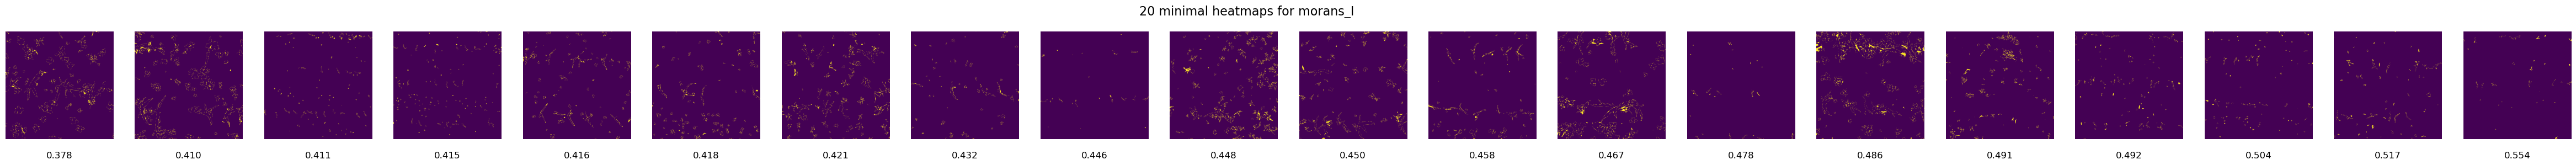

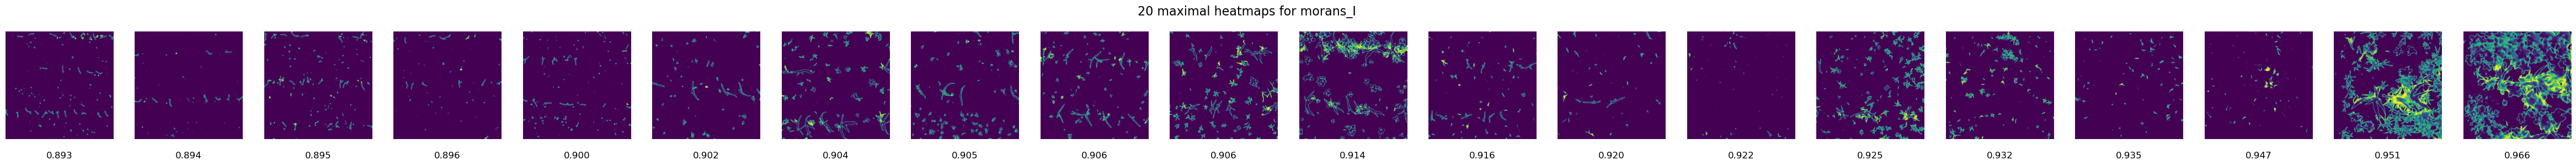

Geary's C


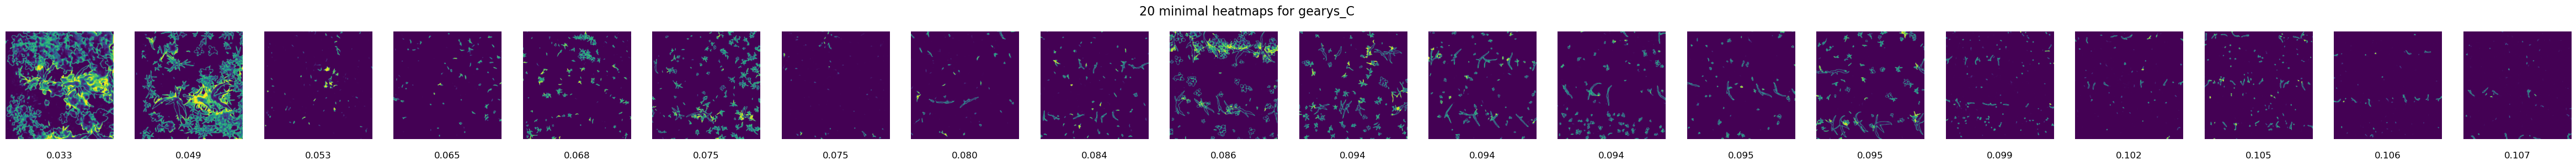

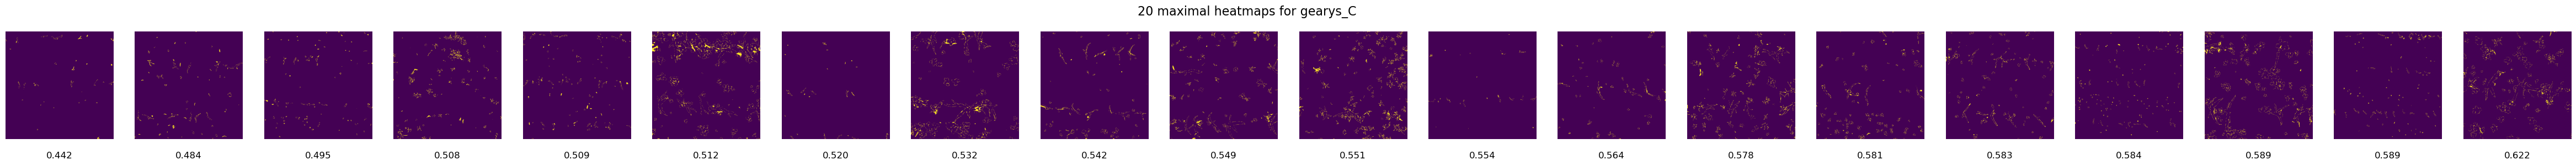

GLCM


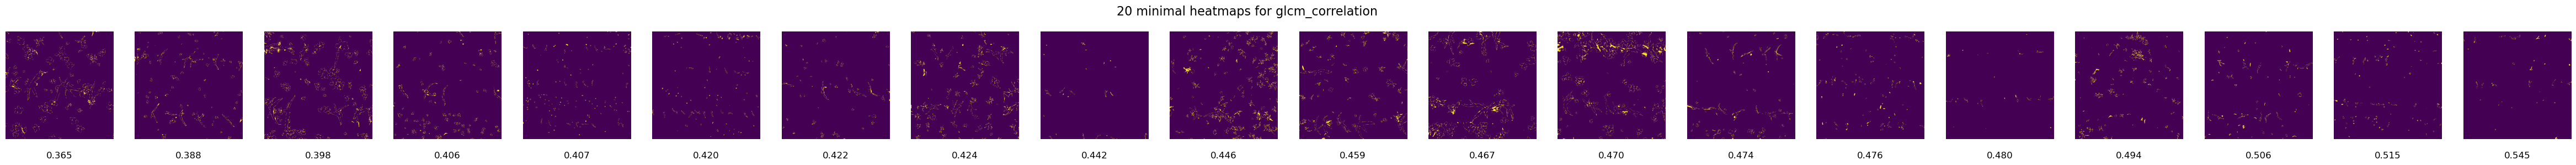

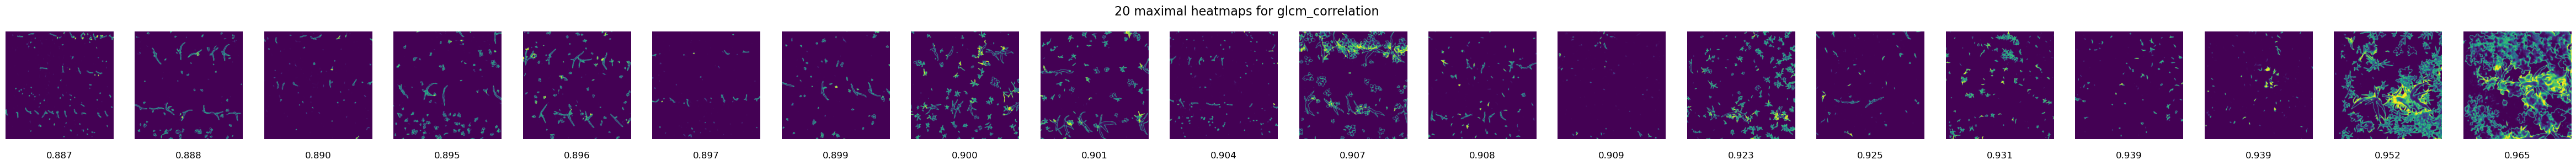

In [15]:
# Moran's I
print("Moran's I")
plot_extremal_heatmaps(arrays, "morans_I", 20)
# Geary's C
print("Geary's C")
plot_extremal_heatmaps(arrays, "gearys_C", 20)
# GLCM
print("GLCM")
plot_extremal_heatmaps(arrays, "glcm_correlation", 20)

## Correlation Matrix

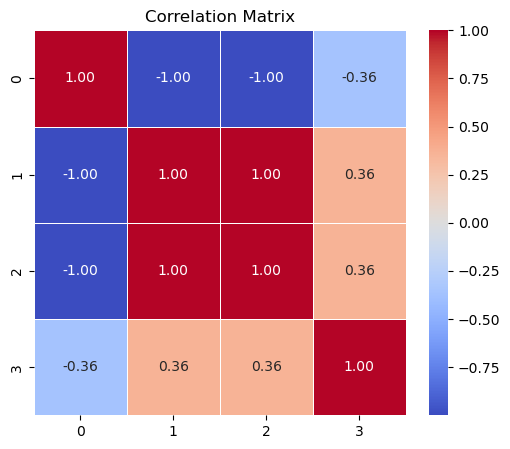

In [16]:
# Compute correlation matrix
df = spatial_df[filenames].T
corr_matrix = df.corr()

# Plot the correlation matrix
plt.figure(figsize=(6, 5))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

##  Range of Aggregation Scores

For each metric we are interested how well the capture the variety of uncertainty heatmaps present in the dataset.
Ideally, a good score should have a high range of values, indicating its ability to capture qualitative differences across heatmaps.

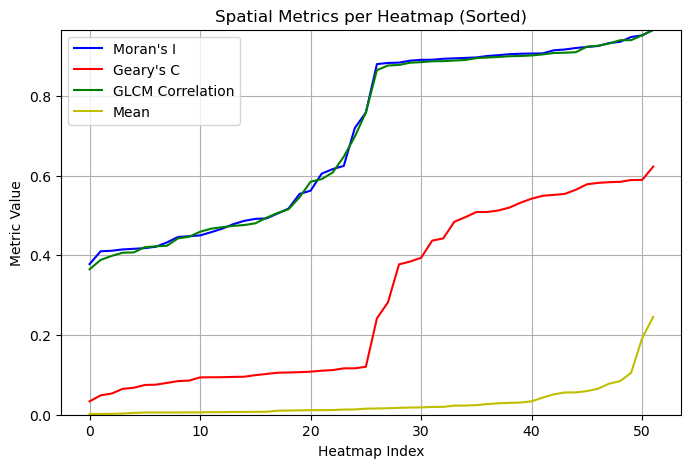

In [17]:
def sort_vals(df, method):
    geary_vals = df[df["Name"]==method].values[:,1:].tolist()[0]
    sorted_indices = np.argsort(geary_vals)  # Indices that would sort geary_vals
    sorted_values = np.array(geary_vals)[sorted_indices]  # Sort values
    return sorted_values

moran_val = sort_vals(spatial_df, "morans_I")
geary_val = sort_vals(spatial_df, "gearys_C")
glcm_val = sort_vals(spatial_df, "glcm_correlation")
mean_val = sort_vals(spatial_df, "mean")
x = [i for i, _ in enumerate(filenames)]

# Plot
plt.figure(figsize=(8, 5))
plt.plot(x, moran_val, linestyle="-", color="b", label="Moran's I")
plt.plot(x, geary_val, linestyle="-", color="r", label="Geary's C")
plt.plot(x, glcm_val, linestyle="-", color="g", label="GLCM Correlation")
plt.plot(x, mean_val, linestyle="-", color="y", label="Mean")
# Labels, title, and legend
plt.xlabel("Heatmap Index")
plt.ylabel("Metric Value")
plt.title("Spatial Metrics per Heatmap (Sorted)")
# Get max y-value for setting the axis limits
max_y = max(max(moran_val), max(geary_val), max(glcm_val))
plt.ylim(0, max_y)  # Set y-axis range
plt.grid(True)
plt.legend(loc="upper left")  # Show legend with appropriate labels
# Show plot
plt.show()


# Counterexamples

Goal: Find heatmaps that have similar mean but different spatial correlation metrics.

In [18]:
method_names = spatial_df["Name"].tolist()
# Sort all columns based on values in the "mean" row
sorted_columns = spatial_df[filenames].loc[method_names.index("mean")].sort_values().index
# Reorder columns in reduced_df (keeping "Name" as the first column)
sorted_df = spatial_df[["Name"]+sorted_columns.tolist()]
sorted_df

,Name,test_23_error.npy,test_26_error.npy,test_17_error.npy,test_20_error.npy,test_26_entropy.npy,test_22_error.npy,test_17_entropy.npy,test_25_error.npy,test_04_error.npy,...,test_18_entropy.npy,test_05_entropy.npy,test_02_entropy.npy,test_08_entropy.npy,test_15_entropy.npy,test_14_error.npy,test_11_entropy.npy,test_01_error.npy,test_14_entropy.npy,test_01_entropy.npy
0,gearys_C,0.553922,0.384162,0.519686,0.442191,0.075347,0.436725,0.106735,0.281997,0.495486,...,0.093680,0.116416,0.111939,0.116282,0.074632,0.393709,0.085562,0.241789,0.048543,0.033493
1,morans_I,0.445817,0.616091,0.477954,0.553829,0.922385,0.561981,0.890310,0.719172,0.504456,...,0.906276,0.883150,0.888047,0.882321,0.924781,0.604627,0.914147,0.757947,0.951489,0.965671
2,glcm_correlation,0.480117,0.591002,0.442366,0.545471,0.909301,0.584502,0.886477,0.697652,0.515314,...,0.899790,0.875994,0.884382,0.877240,0.923229,0.607579,0.907374,0.758102,0.951930,0.964894
3,mean,0.001803,0.001967,0.002242,0.003072,0.004600,0.005622,0.005625,0.005636,0.005639,...,0.051097,0.055784,0.055951,0.059247,0.065164,0.077844,0.084269,0.105006,0.192145,0.245265


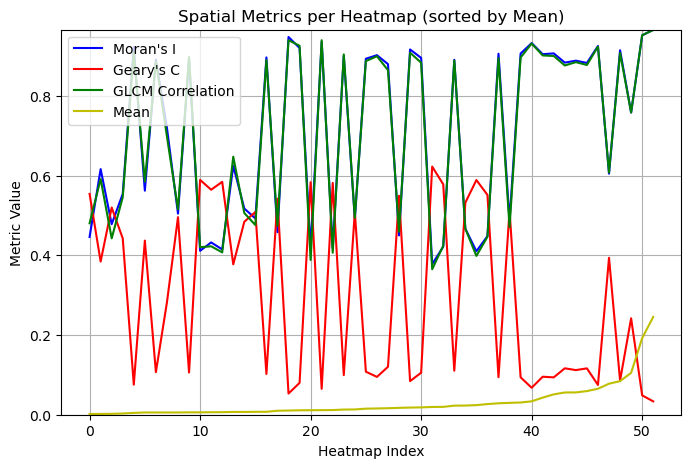

In [19]:
moran_val = list(sorted_df[sorted_columns].loc[method_names.index("morans_I")])
geary_val = list(sorted_df[sorted_columns].loc[method_names.index("gearys_C")])
glcm_val = list(sorted_df[sorted_columns].loc[method_names.index("glcm_correlation")])
mean_val = list(sorted_df[sorted_columns].loc[method_names.index("mean")])
x = [i for i, _ in enumerate(filenames)]

# Plot
plt.figure(figsize=(8, 5))
plt.plot(x, moran_val, linestyle="-", color="b", label="Moran's I")
plt.plot(x, geary_val, linestyle="-", color="r", label="Geary's C")
plt.plot(x, glcm_val, linestyle="-", color="g", label="GLCM Correlation")
plt.plot(x, mean_val, linestyle="-", color="y", label="Mean")
# Labels, title, and legend
plt.xlabel("Heatmap Index")
plt.ylabel("Metric Value")
plt.title("Spatial Metrics per Heatmap (sorted by Mean)")
# Get max y-value for setting the axis limits
max_y = max(max(moran_val), max(geary_val), max(glcm_val))
plt.ylim(0, max_y)  # Set y-axis range
plt.grid(True)
plt.legend(loc="upper left")  # Show legend with appropriate labels
# Show plot
plt.show()

We see that only Geary's C does have strong variance in values among heatmaps sharing the same mean.
Let us extract heatmaps that have minimal and maximal Geary's C while having similar mean.

In [20]:
# Find a heatmap file that has similar mean but different Geary's C
def min_max_heatmap(method):
    values = sorted_df[filenames].astype(float)
    filtered_columns = values.loc[method_names.index("mean")].between(0.005,0.01)
    selected_columns = values.columns[filtered_columns].tolist()
    selected_df = values[selected_columns]

    # Extract row with index 1
    method_row = selected_df.loc[method_names.index(method)]

    # Find column names for min and max values
    min_col = method_row.idxmin()  # Column with min value
    print("Min: ", method_row.min())
    max_col = method_row.idxmax()  # Column with max value
    print("Max: ", method_row.max())
    return [min_col, max_col]

min_max_heatmap("gearys_C")

Min:  0.10222567969457559
Max:  0.5889510319571882


['test_20_entropy.npy', 'test_13_error.npy']

Example for Geary's C
Min:  0.10222567969457559
Max:  0.5889510319571882


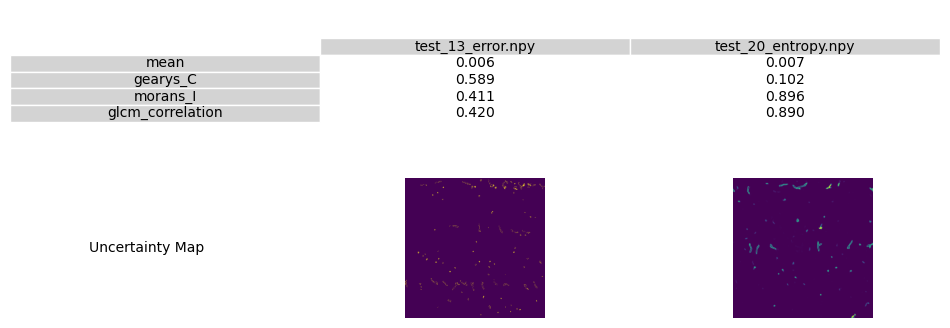

,Name,test_13_error.npy,test_20_entropy.npy
0,mean,0.005978,0.007351
1,gearys_C,0.588951,0.102226
2,morans_I,0.411203,0.896175
3,glcm_correlation,0.420216,0.889738


In [ ]:
# Plot heatmaps having similar mean but different spatial metric scores:

print("Example for Geary's C")
min_max_files = min_max_heatmap("gearys_C")
min_max_unc_maps = [unc_map for unc_map in unc_maps if unc_map.name in min_max_files]

strategy_list = [(am.mean, None), (am.gearys_C, None), (am.morans_I, None), (am.glcm_correlation, None)]
summary = AggregationSummary(strategy_list, name="min_max_gearys_C")
summary.apply_methods(min_max_unc_maps, save_to_excel=False, do_plot=True, max_value=1.0)
